## Silmutaneous tuning of max_terms & max_degree hyperaparameters

In [ ]:
y_pred = model3.predict(X_test)
# Convert y_pred array to a DataFrame
df_pred = pd.DataFrame({'y_pred': y_pred})

# Save the DataFrame to a CSV file
df_pred.to_csv('predictions.csv', index=False)


### The model developed post-tuning with 50 terms (making it less complex) and the degree that minimizes MAE, d = 1, achieved an MAE of USD 36813.04.

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error
from pyearth import Earth

# Create the MARS model
mars_model = Earth(max_terms = 50, max_degree=1)

# Create the bagging regressor with the MARS model
bagged_model = BaggingRegressor(base_estimator=mars_model, n_estimators=200, random_state=42)

# Fit the bagged model to the training data
bagged_model.fit(X_train, y_train)

# Predict on the test data
y_pred = bagged_model.predict(X_test)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)

# Print the MAE
print("MAE: ", mae)

MAE:  36566.447101160484


In [ ]:
import pandas as pd

# Convert y_pred array to a DataFrame
bag_pred = pd.DataFrame({'y_pred': y_pred})

# Save the DataFrame to a CSV file
bag_pred.to_csv('predictions.csv', index=False)


## **AI & ML salaries during 2020-2023**

###By Christina Tzavara, Sarah Abdulwahid, Alex Olmeta, Catherine Tawadros, Charles Bugayer

In [9]:
import pandas as pd
from pyearth import Earth
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import KNNImputer
import xgboost as xgb
import itertools as it
import time as time 
import warnings
warnings.filterwarnings('ignore')

## Data quality check / cleaning / preparation 


In [3]:
# read data

salaries = pd.read_csv("salaries.csv")
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,MI,FT,AWS Data Architect,258000,USD,258000,US,100,US,L
1,2023,SE,FT,Data Scientist,225000,USD,225000,US,0,US,M
2,2023,SE,FT,Data Scientist,156400,USD,156400,US,0,US,M
3,2023,SE,FT,Data Engineer,190000,USD,190000,US,100,US,M
4,2023,SE,FT,Data Engineer,150000,USD,150000,US,100,US,M


In [4]:
salaries.shape

(4134, 11)

#### **In this dataset, there are 4134 observations and there are 10 predictor, since we are using salary_in_usd as a response for our data analysis. The reason for this is that we want the data to be standardized across countries.**

### Distribution of response
*By Christina Tzavara*

<Figure size 1000x500 with 0 Axes>

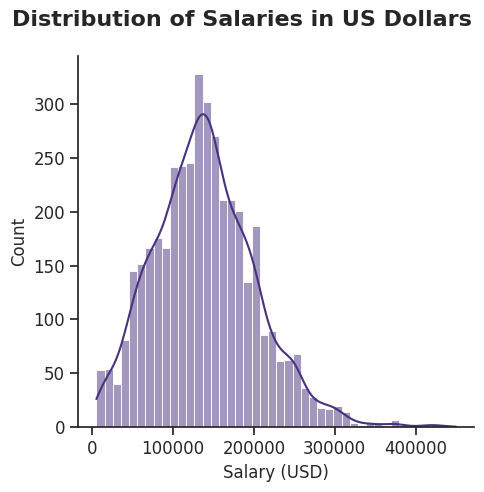

In [13]:
#Plotting distribution of our response variable, salary_in_usd

sns.set(style='ticks', palette='viridis')
plt.figure(figsize=(10, 5))
g = sns.displot(salaries['salary_in_usd'], kde=True)

# Setting plot title and axis labels with larger, bold font
g.fig.suptitle("Distribution of Salaries in US Dollars", fontsize=16, fontweight='bold')
g.set(xlabel="Salary (USD)", ylabel="Count")

# Customizing tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove the right and top spines
sns.despine(right=True, top=True)

# Adjustting plot layout
plt.tight_layout()
plt.show()


### Data cleaning
*Note: dataset is completely clean as shown below*

In [6]:
# Check for missing values
missing_values = salaries.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


### Data preparation
*By Alex Olmeta*

- We needed to bin the hundreds of job titles in 10 main categories since the names for the job positions weren't standardized.
- Alex, add comments to your code below as per the instructions

In [ ]:
salaries.job_title_binned.value_counts()

data_science_and_ml                  1534
data_engineering_and_architecture    1474
data_analysis_and_visualization       692
data_management_and_strategy          146
research_and_science                  133
business_intelligence                  50
other_data_related                     49
computer_vision                        29
ai_development                         16
nlp_engineer                           11
Name: job_title_binned, dtype: int64

In [ ]:
job_categories = {
    'data_science_and_ml': ['Data Scientist', 'Applied Scientist', 'ML Engineer', 'Machine Learning Engineer', 'Applied Machine Learning Engineer', 'Research Engineer', 'Machine Learning Developer', 'Machine Learning Scientist', 'AI Scientist', 'Machine Learning Software Engineer', 'Principal Data Scientist', 'Machine Learning Researcher', 'Decision Scientist', 'Machine Learning Research Engineer', 'Principal Machine Learning Engineer', 'Machine Learning Manager', 'Lead Machine Learning Engineer', 'Principal Data Analyst', 'Staff Data Scientist', 'Applied Machine Learning Scientist', 'Lead Data Scientist'],
    'data_engineering_and_architecture': ['AWS Data Architect', 'Data Engineer', 'Data Manager', 'Data Architect', 'Data Integration Specialist', 'ETL Developer', 'BI Data Analyst', 'Data Modeler', 'Cloud Data Engineer', 'Data Operations Analyst', 'ETL Engineer', 'Data DevOps Engineer', 'Data Quality Analyst', 'Big Data Engineer', 'BI Data Engineer', 'Cloud Database Engineer', 'Data Infrastructure Engineer', 'Software Data Engineer', 'Data Operations Engineer', 'Big Data Architect', 'Azure Data Engineer', 'Marketing Data Engineer', 'Data Management Specialist', 'Principal Data Architect', 'Cloud Data Architect', 'Principal Data Engineer', 'Machine Learning Infrastructure Engineer', 'MLOps Engineer', 'Analytics Engineer'],
    'data_analysis_and_visualization': ['Data Analyst', 'Product Data Analyst', 'Data Visualization Analyst', 'Sales Data Analyst', 'BI Developer', 'Business Data Analyst', 'Lead Data Analyst', 'BI Analyst', 'Insight Analyst', 'Marketing Data Analyst', 'Data Analytics Lead'],
    'data_management_and_strategy': ['Head of Data', 'Data Specialist', 'Director of Data Science', 'Data Science Manager', 'Data Science Lead', 'Data Strategist', 'Data Analytics Manager', 'Manager Data Management', 'Data Management Specialist'],
    'ai_development': ['Autonomous Vehicle Operations Lead', 'Autonomous Vehicle Technician', 'AI Developer', 'AI Programmer'],
    'computer_vision': ['Computer Vision Engineer', 'Computer Vision Software Engineer', '3D Computer Vision Researcher'],
    'nlp_engineer': ['NLP Engineer'],
    'business_intelligence': ['Business Intelligence Engineer', 'BI Data Analyst', 'BI Developer', 'BI Data Engineer', 'BI Analyst', 'Power BI Developer'],
    'research_and_science': ['Research Scientist', 'Applied Data Scientist', 'Data Science Consultant', 'Deep Learning Researcher', 'Deep Learning Engineer'],
    'other_data_related': ['Finance Data Analyst', 'Compliance Data Analyst', 'Data Science Tech Lead', 'Marketing Data Scientist', 'Product Data Scientist', 'Staff Data Analyst', 'Data Analytics Specialist', 'Data Analytics Engineer', 'Data Analytics Consultant', 'Data Management Specialist', 'Head of Data Science', 'Data Lead', 'Data Science Engineer', 'Insight Analyst', 'Data Science Engineer', 'Data Analytics Engineer', 'Data Analytics Consultant', 'Data Management Specialist', 'Data Scientist Lead', 'Principal Data Architect', 'Lead Data Engineer', 'Head of Machine Learning', 'Staff Data Scientist', 'Financial Data Analyst']
}

In [ ]:
# check to make sure all jobs fall in a category

not_cat = []
for i in range(len(salaries.job_title)):
    title = salaries.job_title[i]
    categorized = False
    for key in job_categories.keys():
        cat = job_categories[key]
        if title in cat:
            categorized = True
    if not categorized:
        not_cat.append(title)

list(set(not_cat))

[]

In [ ]:
# bin jobs based on category

binned_jobs = [None] * len(salaries.job_title)
for i in range(len(salaries.job_title)):
    title = salaries.job_title[i]
    categorized = False
    for key in job_categories.keys():
        cat = job_categories[key]
        if title in cat:
            binned_jobs[i] = key


salaries['job_title_binned'] = binned_jobs

In [ ]:
len(salaries.job_title_binned.unique())

10

In [ ]:
salaries.to_csv('binned_jobs.csv', index=False) 

## Exploratory data analysis
*By Christina Tzavara*

In [4]:
binned_jobs = pd.read_csv("binned_jobs.csv")
binned_jobs =  binned_jobs.drop('job_title', axis = 1)
binned_jobs =  binned_jobs.drop('salary', axis = 1)
#check updated dataset with new column job_title_binned
binned_jobs.head()

,work_year,experience_level,employment_type,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_binned
0,2023,MI,FT,USD,258000,US,100,US,L,data_engineering_and_architecture
1,2023,SE,FT,USD,225000,US,0,US,M,data_science_and_ml
2,2023,SE,FT,USD,156400,US,0,US,M,data_science_and_ml
3,2023,SE,FT,USD,190000,US,100,US,M,data_engineering_and_architecture
4,2023,SE,FT,USD,150000,US,100,US,M,data_engineering_and_architecture


In [ ]:
import pandas as pd
from tabulate import tabulate

# Compute summary statistics for 'salary_in_usd'
salary_stats = salaries['salary_in_usd'].describe().reset_index()
salary_stats.columns = ['Statistic', 'Value']

# Convert the summary statistics to a table
salary_table = tabulate(salary_stats, headers='keys', tablefmt='fancy_grid', showindex=False)
print("Summary Statistics for 'salary_in_usd':")
print(salary_table)


Summary Statistics for 'salary_in_usd':
╒═════════════╤══════════╕
│ Statistic   │    Value │
╞═════════════╪══════════╡
│ count       │   4134   │
├─────────────┼──────────┤
│ mean        │ 139416   │
├─────────────┼──────────┤
│ std         │  63605.5 │
├─────────────┼──────────┤
│ min         │   5132   │
├─────────────┼──────────┤
│ 25%         │  96817   │
├─────────────┼──────────┤
│ 50%         │ 136000   │
├─────────────┼──────────┤
│ 75%         │ 179820   │
├─────────────┼──────────┤
│ max         │ 450000   │
╘═════════════╧══════════╛


#### **Looking at the average values for our repsonse per job title:**

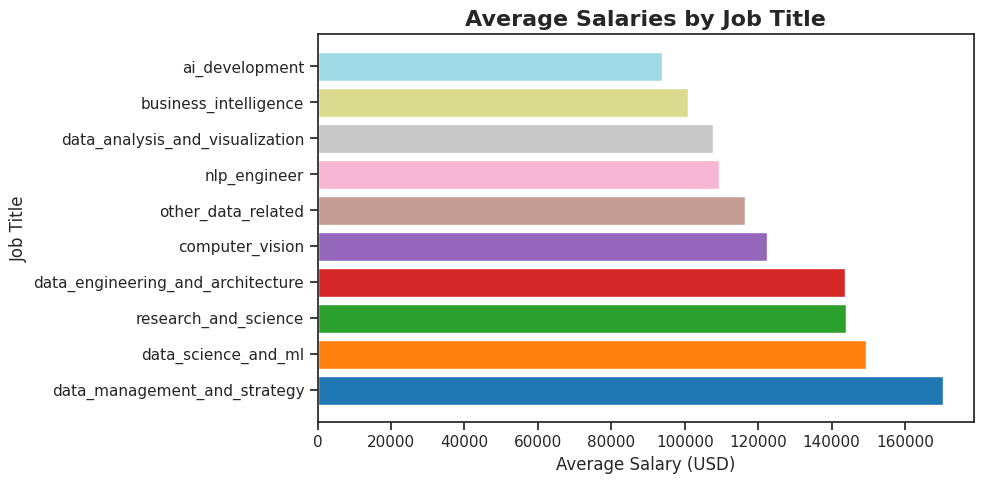

In [12]:

# Group the data by job title and calculate the average salary
average_salary_by_title = binned_jobs.groupby('job_title_binned')['salary_in_usd'].mean().sort_values(ascending=False)

# Create a bar plot with each job title having its own color
plt.figure(figsize=(10, 5))

# Generate a color map with a unique color for each job title
color_map = plt.get_cmap('tab20', len(average_salary_by_title))

# Get the list of job titles and corresponding average salaries
job_titles = average_salary_by_title.index
average_salaries = average_salary_by_title.values

# Plot each bar with a unique color
for i in range(len(job_titles)):
    plt.barh(job_titles[i], average_salaries[i], color=color_map(i))

plt.xlabel('Average Salary (USD)')
plt.ylabel('Job Title')

# Customize the title
plt.title('Average Salaries by Job Title', fontweight='bold', fontsize=16)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


## Developing the model: Hyperparameter tuning

### MARS 
*By Christina Tzavara*

### First, running a general baseline model:

In [5]:
binned_jobs_encoded = pd.get_dummies(binned_jobs, drop_first=True)
X = binned_jobs_encoded.drop('salary_in_usd',axis=1)
y = binned_jobs_encoded['salary_in_usd']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Create a baseline linear regression model
baseline_model = LinearRegression()

# Fit the model on the training data
baseline_model.fit(X_train, y_train)

# Predict on the test data
y_pred = baseline_model.predict(X_test)


In [10]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: $", mae)

Mean Absolute Error: $ 280696947960.07605


### Developing MARS initial model by finding max_degree that minimizes MAE:

In [ ]:
from sklearn.model_selection import GridSearchCV
from pyearth import Earth

# Define the parameter grid
param_grid = {
    'max_degree': [1, 2, 3, 4, 5]  # Vary the max_degree values as needed
}


mars = Earth()
#MAE as the scoring metric
grid_search = GridSearchCV(mars, param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best model max_degree and MAE
print("Best Model max_degree: ", grid_search.best_params_['max_degree'])
print("MAE: ", -grid_search.best_score_)  # Convert negative score back to positive


Best Model max_degree:  1
MAE:  37315.428132284724


### Visualizing max_degree - MAE trade-off:

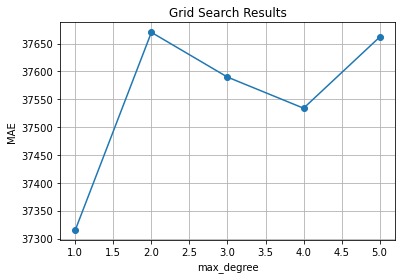

In [ ]:
import matplotlib.pyplot as plt

# Get the max_degree values and corresponding mean_test_score
max_degrees = grid_search.cv_results_['param_max_degree'].data.astype(int)
mae_scores = -grid_search.cv_results_['mean_test_score']

# Plot 
plt.plot(max_degrees, mae_scores, marker='o')
plt.xlabel('max_degree')
plt.ylabel('MAE')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()


### Second MARS model after silmutaneous tuning of max_terms & max_degree:

In [ ]:
# Finer search for degree + silmutaneous tuning for max terms

#Define the parameter grid
param_grid = {
    'max_terms': [50,100, 200],  # Vary the max_terms values as needed
    'max_degree': [1, 2, 3]  # Vary the degree values as needed
}

mars = Earth()

#MAE as the scoring metric
grid_search = GridSearchCV(mars, param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

{'max_degree': 1, 'max_terms': 50}

### Visualizing max_terms vs MAE:

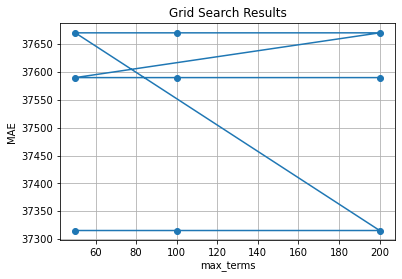

In [ ]:
# Get the max_degree values and corresponding mean_test_score
max_degrees = grid_search.cv_results_['param_max_terms'].data.astype(int)
mae_scores = -grid_search.cv_results_['mean_test_score']

# Plot
plt.plot(max_degrees, mae_scores, marker='o')
plt.xlabel('max_terms')
plt.ylabel('MAE')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()


### Final optimized model MAE:

In [ ]:
model3 = Earth(max_terms = 50, max_degree=1) # note, terms in brackets are the hyperparameters 
model3.fit(X_train,y_train)

# Predict on the test data using the best model
y_pred = model3.predict(X_test)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Print the mean absolute error
print("Mean Absolute Error: $", mae)


Mean Absolute Error: $ 36813.0367444063


### Decision trees with Cost Complexity Pruning & Bagging
*By Sarah Abdulwahid*

### Bagged trees & Random forest
*By Fiona Fe*

### XGBoost
*By Ryu Kimiko*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.